In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot

from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import anderson
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.graphics.gofplots import qqplot
from scipy import stats

In [2]:
#import the data
churndf = pd.read_csv("churndata.csv")

In [3]:
#Getting a peak into the data
churndf.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
churndf.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

We see that TotalCharges column is an object but it should be float
Similarly The Seniorcitizen column is encoded as 0 and 1, need to change it to Yes or No to get the column in str type rather then an integer type because it is an categorical column

In [5]:
#Converting Totalcharges to float and filling up its missing values
churndf['TotalCharges'] = pd.to_numeric(churndf['TotalCharges'],errors='coerce')
churndf['TotalCharges']=churndf['TotalCharges'].fillna(churndf['TotalCharges'].mean())
#encoding 0 to No and 1 to Yes in SeniorCitizen column (only coverting to str was not 
#enough since gds reads it as integer)
churndf['SeniorCitizen']=churndf['SeniorCitizen'].astype(str)
churndf['SeniorCitizen']=churndf['SeniorCitizen'].replace('0','No')
churndf['SeniorCitizen']=churndf['SeniorCitizen'].replace('1','Yes')

In [6]:
churndf.dtypes

customerID           object
gender               object
SeniorCitizen        object
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

Data types are correct now

In [7]:
churndf.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

No nulls

Doing Chi2 test of independence between all the categorical columns and churn

In [8]:
data_crosstab = pd.crosstab(churndf['Churn'], churndf['PaymentMethod'], 
margins = False) 
print(data_crosstab) 

stat, p, dof, expected = chi2_contingency(data_crosstab)
print('dof=%d' % dof)
print(expected)

# interpret p-value
alpha = 0.05
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')


PaymentMethod  Bank transfer (automatic)  Credit card (automatic)  \
Churn                                                               
No                                  1286                     1290   
Yes                                  258                      232   

PaymentMethod  Electronic check  Mailed check  
Churn                                          
No                         1294          1304  
Yes                        1071           308  
dof=3
[[1134.26891949 1118.10705665 1737.40025557 1184.22376828]
 [ 409.73108051  403.89294335  627.59974443  427.77623172]]
significance=0.050, p=0.000
Dependent (reject H0)


This is an exception where i have done the test of independence between payment method and internet service to see there relationship

In [9]:
data_crosstab = pd.crosstab(churndf['PaymentMethod'], churndf['InternetService'], 
margins = False) 
print(data_crosstab) 

stat, p, dof, expected = chi2_contingency(data_crosstab)
print('dof=%d' % dof)
print(expected)

# interpret p-value
alpha = 0.05
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

InternetService            DSL  Fiber optic   No
PaymentMethod                                   
Bank transfer (automatic)  566          646  332
Credit card (automatic)    594          597  331
Electronic check           648         1595  122
Mailed check               613          258  741
dof=6
[[ 530.74314923  678.71986369  334.53698708]
 [ 523.18074684  669.04898481  329.77026835]
 [ 812.95825642 1039.61948034  512.42226324]
 [ 554.11784751  708.61167116  349.27048133]]
significance=0.050, p=0.000
Dependent (reject H0)


In [10]:
data_crosstab = pd.crosstab(churndf['Churn'], churndf['PaperlessBilling'], 
margins = False) 
print(data_crosstab) 

stat, p, dof, expected = chi2_contingency(data_crosstab)
print('dof=%d' % dof)
print(expected)

# interpret p-value
alpha = 0.05
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

PaperlessBilling    No   Yes
Churn                       
No                2403  2771
Yes                469  1400
dof=1
[[2109.85773108 3064.14226892]
 [ 762.14226892 1106.85773108]]
significance=0.050, p=0.000
Dependent (reject H0)


In [11]:
data_crosstab = pd.crosstab(churndf['Churn'], churndf['Contract'], 
margins = False) 
print(data_crosstab) 

stat, p, dof, expected = chi2_contingency(data_crosstab)
print('dof=%d' % dof)
print(expected)

# interpret p-value
alpha = 0.05
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

Contract  Month-to-month  One year  Two year
Churn                                       
No                  2220      1307      1647
Yes                 1655       166        48
dof=2
[[2846.69175067 1082.11018032 1245.198069  ]
 [1028.30824933  390.88981968  449.801931  ]]
significance=0.050, p=0.000
Dependent (reject H0)


In [12]:
data_crosstab = pd.crosstab(churndf['Churn'], churndf['StreamingMovies'], 
margins = False) 
print(data_crosstab) 

stat, p, dof, expected = chi2_contingency(data_crosstab)
print('dof=%d' % dof)
print(expected)

# interpret p-value
alpha = 0.05
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

StreamingMovies    No  No internet service   Yes
Churn                                           
No               1847                 1413  1914
Yes               938                  113   818
dof=2
[[2045.94490984 1121.04557717 2007.00951299]
 [ 739.05509016  404.95442283  724.99048701]]
significance=0.050, p=0.000
Dependent (reject H0)


In [13]:
data_crosstab = pd.crosstab(churndf['Churn'], churndf['StreamingTV'], 
margins = False) 
print(data_crosstab) 

stat, p, dof, expected = chi2_contingency(data_crosstab)
print('dof=%d' % dof)
print(expected)

# interpret p-value
alpha = 0.05
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

StreamingTV    No  No internet service   Yes
Churn                                       
No           1868                 1413  1893
Yes           942                  113   814
dof=2
[[2064.31066307 1121.04557717 1988.64375976]
 [ 745.68933693  404.95442283  718.35624024]]
significance=0.050, p=0.000
Dependent (reject H0)


In [14]:
data_crosstab = pd.crosstab(churndf['Churn'], churndf['TechSupport'], 
margins = False) 
print(data_crosstab) 

stat, p, dof, expected = chi2_contingency(data_crosstab)
print('dof=%d' % dof)
print(expected)

# interpret p-value
alpha = 0.05
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

TechSupport    No  No internet service   Yes
Churn                                       
No           2027                 1413  1734
Yes          1446                  113   310
dof=2
[[2551.37043873 1121.04557717 1501.5839841 ]
 [ 921.62956127  404.95442283  542.4160159 ]]
significance=0.050, p=0.000
Dependent (reject H0)


In [15]:
data_crosstab = pd.crosstab(churndf['Churn'], churndf['DeviceProtection'], 
margins = False) 
print(data_crosstab) 

stat, p, dof, expected = chi2_contingency(data_crosstab)
print('dof=%d' % dof)
print(expected)

# interpret p-value
alpha = 0.05
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

DeviceProtection    No  No internet service   Yes
Churn                                            
No                1884                 1413  1877
Yes               1211                  113   545
dof=2
[[2273.68024989 1121.04557717 1779.27417294]
 [ 821.31975011  404.95442283  642.72582706]]
significance=0.050, p=0.000
Dependent (reject H0)


In [16]:
data_crosstab = pd.crosstab(churndf['Churn'], churndf['OnlineBackup'], 
margins = False) 
print(data_crosstab) 

stat, p, dof, expected = chi2_contingency(data_crosstab)
print('dof=%d' % dof)
print(expected)

# interpret p-value
alpha = 0.05
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

OnlineBackup    No  No internet service   Yes
Churn                                        
No            1855                 1413  1906
Yes           1233                  113   523
dof=2
[[2268.53783899 1121.04557717 1784.41658384]
 [ 819.46216101  404.95442283  644.58341616]]
significance=0.050, p=0.000
Dependent (reject H0)


In [17]:
data_crosstab = pd.crosstab(churndf['Churn'], churndf['OnlineSecurity'], 
margins = False) 
print(data_crosstab) 

stat, p, dof, expected = chi2_contingency(data_crosstab)
print('dof=%d' % dof)
print(expected)

# interpret p-value
alpha = 0.05
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

OnlineSecurity    No  No internet service   Yes
Churn                                          
No              2037                 1413  1724
Yes             1461                  113   295
dof=2
[[2569.73619196 1121.04557717 1483.21823087]
 [ 928.26380804  404.95442283  535.78176913]]
significance=0.050, p=0.000
Dependent (reject H0)


In [18]:
data_crosstab = pd.crosstab(churndf['Churn'], churndf['InternetService'], 
margins = False) 
print(data_crosstab) 

stat, p, dof, expected = chi2_contingency(data_crosstab)
print('dof=%d' % dof)
print(expected)

# interpret p-value
alpha = 0.05
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

InternetService   DSL  Fiber optic    No
Churn                                   
No               1962         1799  1413
Yes               459         1297   113
dof=2
[[1778.53954281 2274.41488002 1121.04557717]
 [ 642.46045719  821.58511998  404.95442283]]
significance=0.050, p=0.000
Dependent (reject H0)


In [19]:
data_crosstab = pd.crosstab(churndf['Churn'], churndf['MultipleLines'], 
margins = False) 
print(data_crosstab) 

stat, p, dof, expected = chi2_contingency(data_crosstab)
print('dof=%d' % dof)
print(expected)

# interpret p-value
alpha = 0.05
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

MultipleLines    No  No phone service   Yes
Churn                                      
No             2541               512  2121
Yes             849               170   850
dof=2
[[2490.39613801  501.01774812 2182.58611387]
 [ 899.60386199  180.98225188  788.41388613]]
significance=0.050, p=0.003
Dependent (reject H0)


In [20]:
data_crosstab = pd.crosstab(churndf['Churn'], churndf['PhoneService'], 
margins = False) 
print(data_crosstab) 

stat, p, dof, expected = chi2_contingency(data_crosstab)
print('dof=%d' % dof)
print(expected)

# interpret p-value
alpha = 0.05
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

PhoneService   No   Yes
Churn                  
No            512  4662
Yes           170  1699
dof=1
[[ 501.01774812 4672.98225188]
 [ 180.98225188 1688.01774812]]
significance=0.050, p=0.339
Independent (fail to reject H0)


This chi sqr test indicates that churn and phoneService are independent so we are not going to take this into the dashboard    

In [21]:
data_crosstab = pd.crosstab(churndf['Churn'], churndf['Dependents'], 
margins = False) 
print(data_crosstab) 

stat, p, dof, expected = chi2_contingency(data_crosstab)
print('dof=%d' % dof)
print(expected)

# interpret p-value
alpha = 0.05
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

Dependents    No   Yes
Churn                 
No          3390  1784
Yes         1543   326
dof=1
[[3623.93042737 1550.06957263]
 [1309.06957263  559.93042737]]
significance=0.050, p=0.000
Dependent (reject H0)


In [22]:
data_crosstab = pd.crosstab(churndf['Churn'], churndf['Partner'], 
margins = False) 
print(data_crosstab) 

stat, p, dof, expected = chi2_contingency(data_crosstab)
print('dof=%d' % dof)
print(expected)

# interpret p-value
alpha = 0.05
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

Partner    No   Yes
Churn              
No       2441  2733
Yes      1200   669
dof=1
[[2674.78830044 2499.21169956]
 [ 966.21169956  902.78830044]]
significance=0.050, p=0.000
Dependent (reject H0)


In [23]:
data_crosstab = pd.crosstab(churndf['Churn'], churndf['SeniorCitizen'], 
margins = False) 
print(data_crosstab) 

stat, p, dof, expected = chi2_contingency(data_crosstab)
print('dof=%d' % dof)
print(expected)

# interpret p-value
alpha = 0.05
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

SeniorCitizen    No  Yes
Churn                   
No             4508  666
Yes            1393  476
dof=1
[[4335.05239245  838.94760755]
 [1565.94760755  303.05239245]]
significance=0.050, p=0.000
Dependent (reject H0)


In [24]:
data_crosstab = pd.crosstab(churndf['Churn'], churndf['gender'], 
margins = False) 
print(data_crosstab) 

stat, p, dof, expected = chi2_contingency(data_crosstab)
print('dof=%d' % dof)
print(expected)

# interpret p-value
alpha = 0.05
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

gender  Female  Male
Churn               
No        2549  2625
Yes        939   930
dof=1
[[2562.38989067 2611.61010933]
 [ 925.61010933  943.38989067]]
significance=0.050, p=0.487
Independent (fail to reject H0)


This chi sqr test indicates that churn and gender are independent so we are not going to take this into the dashboard 

Now we start to do anova of each numeric column with churn

In [25]:
col = churndf['tenure']
model = ols('col ~ C(Q("Churn"))', data=churndf).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print ("\nAnova => Tenure - Churn")
display(anova_table)


Anova => Tenure - Churn


,sum_sq,df,F,PR(>F)
"C(Q(""Churn""))",5.269675e+05,1.0,997.26801,7.999058e-205
Residual,3.720542e+06,7041.0,NaN,NaN


The avg number of tenure is siginificantly different for churn classes. Lets do Tukey (below) and see the actual difference

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper   reject
-----------------------------------------------------
    No    Yes -19.5908 0.001 -20.8069 -18.3747   True
-----------------------------------------------------


<AxesSubplot:>

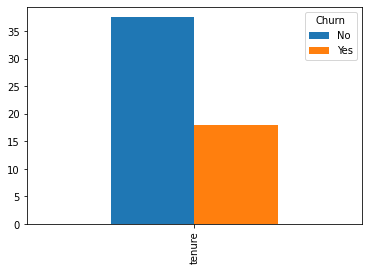

In [26]:
tukey = pairwise_tukeyhsd(endog=churndf['tenure'],
                          groups=churndf['Churn'],
                          alpha=0.05)

#display results
print(tukey)
churndf.pivot_table(columns=['Churn'], values='tenure', aggfunc=np.mean).round(2).plot.bar()

In [27]:
col = churndf['MonthlyCharges']
model = ols('col ~ C(Q("Churn"))', data=churndf).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print ("\nAnova => MonthlyCharges - Churn")
display(anova_table)


Anova => MonthlyCharges - Churn


,sum_sq,df,F,PR(>F)
"C(Q(""Churn""))",2.383740e+05,1.0,273.463704,2.706646e-60
Residual,6.137530e+06,7041.0,NaN,NaN


The avg of Monthly charges is siginificantly different for churn classes. Lets do Tukey (below) and see the actual difference

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
    No    Yes  13.1762 0.001 11.6143 14.7381   True
---------------------------------------------------


<AxesSubplot:>

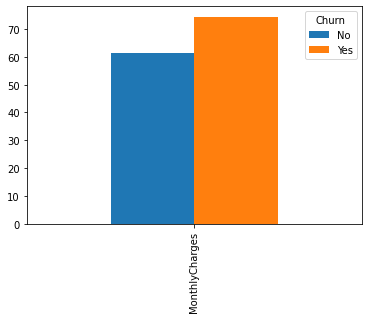

In [28]:
tukey = pairwise_tukeyhsd(endog=churndf['MonthlyCharges'],
                          groups=churndf['Churn'],
                          alpha=0.05)

#display results
print(tukey)
churndf.pivot_table(columns=['Churn'], values='MonthlyCharges', aggfunc=np.mean).round(2).plot.bar()

In [29]:
col = churndf['TotalCharges']
model = ols('col ~ C(Q("Churn"))', data=churndf).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print ("\nAnova => TotalCharges - Churn")
display(anova_table)


Anova => TotalCharges - Churn


,sum_sq,df,F,PR(>F)
"C(Q(""Churn""))",1.436824e+09,1.0,291.629021,4.233836e-64
Residual,3.469023e+10,7041.0,NaN,NaN


The avg of Total charges is siginificantly different for churn classes. Lets do Tukey (below) and see the actual difference

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1 group2  meandiff  p-adj   lower      upper   reject
----------------------------------------------------------
    No    Yes -1022.9697 0.001 -1140.3973 -905.5421   True
----------------------------------------------------------


<AxesSubplot:>

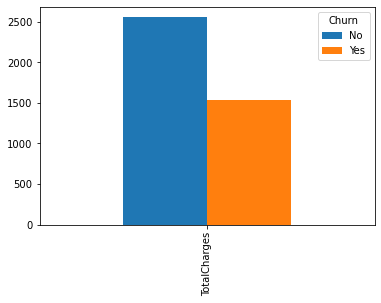

In [30]:
tukey = pairwise_tukeyhsd(endog=churndf['TotalCharges'],
                          groups=churndf['Churn'],
                          alpha=0.05)

#display results
print(tukey)
churndf.pivot_table(columns=['Churn'], values='TotalCharges', aggfunc=np.mean).round(2).plot.bar()

Since we changed certain columns in the main data so now saving the changed data into a new csv to starting making a dashboard based on the wrangling we have done.

In [31]:
churndf.to_csv('Newchurn.csv',index=False)